In [1]:
pd.set_option('display.max_columns', 500)

print(packages_import_statement)

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import r2_score


import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os

import re
import time 

from pprint import pprint




In [2]:
# Get geographic data for each CD
cb_by_borough = pd.read_csv("../data/nta_to_cb_clean.csv",skiprows=4,header=1)[['Borough','Unnamed: 4','Neighborhood Tabulation Area (NTA)']].iloc[1:]
cb_by_borough.columns = ['Borough',"CD","NTA"]
borough_to_code_dict =  {"MN":1
    ,"BX":2
    ,"BK":3
    ,"QN":4
    ,"SI":5}
def make_cb_index_code(row):
    b_code = borough_to_code_dict[row["CD"][0:2]]
    cd_code = row['CD'].split(" ")[-1]
    if len(cd_code)==1:
        cd_code = f"0{cd_code}"
    return f"{b_code}__{cd_code}"
cb_by_borough['communitydistrict_index']=cb_by_borough.apply(make_cb_index_code,axis=1)
cb_by_borough= cb_by_borough[['Borough','communitydistrict_index']].drop_duplicates().reset_index(drop=True)
cb_by_borough.sample(5)

,Borough,communitydistrict_index
55,Queens,4__14
40,Manhattan,1__01
38,Manhattan,1__06
23,Brooklyn,3__07
54,Queens,4__10


In [92]:
cb_by_borough_idx = cb_by_borough.set_index("communitydistrict_index")

In [3]:
def test_train_cds_by_borough(train_ratio=.72):
    
    test_cds = list()
    train_cds = list()
    
    for boro in cb_by_borough["Borough"].unique():
        boro_df = cb_by_borough[cb_by_borough['Borough']==boro]
#         print(boro)
#         print()
        train_cds.extend(boro_df.sample(int(train_ratio*len(boro_df)//1))['communitydistrict_index'].values)
        test_cds.extend(boro_df[~boro_df['communitydistrict_index'].isin(train_cds)]['communitydistrict_index'].values)
        
    return train_cds,test_cds
        
train_cds, test_cds = test_train_cds_by_borough()
print(f"# Train CDs: {len(train_cds)}")
print(f"# Test CDs: {len(test_cds)}")




# Train CDs: 40
# Test CDs: 19


In [29]:
##target variable
diversion_ratechange = pd.read_csv("../modeling_data/Y__Diversion_RateChange.csv")

## input variables_CENSUS
demos = pd.read_csv("../modeling_data/Xs_ACS_DemoData.csv")
econs = pd.read_csv("../modeling_data/Xs_ACS_EconData.csv")

#LOAD DATA IN, JOIN TOGETHER XS AND Y
modeling_df = diversion_ratechange.merge(demos,on='communitydistrict_index',how='left').merge(econs,on='communitydistrict_index',how='left').merge(right=cb_by_borough,on='communitydistrict_index').set_index("communitydistrict_index")

#Bring in dummies for boroughs, drop staten island to avoid perfect multi-colinearity
modeling_df=modeling_df.merge(right=pd.get_dummies(modeling_df['Borough']),left_index=True,right_index=True).drop(["Borough","Staten Island"],axis=1)

orig_income_cats = ["hh_inc<10K","hh_inc10-14K","hh_inc15-24K","hh_inc25-34K","hh_inc35-49K"\
                    ,'hh_inc50-74K','hh_inc75-99K','hh_inc100-149K','hh_inc150-199K','hh_inc>200K']
#Bin Income Categories
modeling_df['hh_inc_0to49K']=modeling_df[["hh_inc<10K","hh_inc10-14K","hh_inc15-24K","hh_inc25-34K","hh_inc35-49K"]].sum(axis=1)
modeling_df['hh_inc_50to99K']=modeling_df[['hh_inc50-74K','hh_inc75-99K']].sum(axis=1)
modeling_df['hh_inc_100-200K']=modeling_df[['hh_inc100-149K','hh_inc150-199K']].sum(axis=1)
modeling_df['hh_inc_200K+']=modeling_df[['hh_inc>200K']].sum(axis=1)
modeling_df.drop(orig_income_cats,axis=1,inplace=True)
modeling_df

,Change_Diversion_Rate_PostLockdown,pop_under_18,pop_over_65,white_alone,black_alone,hispanic,asian_alone,other_race_alone,num_employed,num_unemployed,hh_with_snap_past12mos,num_eployed_info_sector,num_eployed_fire_sector,num_eployed_sciences_waste_sector,num_eployed_educhealthsocial_sector,num_eployed_artsentertainmentfoood_sector,num_eployed_other_sector,num_eployed_publicadmin_sector,Bronx,Brooklyn,Manhattan,Queens,hh_inc_0to49K,hh_inc_50to99K,hh_inc_100-200K,hh_inc_200K+
communitydistrict_index,,,,,,,,,,,,,,,,,,,,,,,,,,
1__01,0.004018,19724,19926,111981,4395,10469,23956,703,97888,3983,2923,7529,22910,26612,15540,8072,2696,1588,0,0,1,0,15589,12945,20910,28196
1__02,-0.013964,19724,19926,111981,4395,10469,23956,703,97888,3983,2923,7529,22910,26612,15540,8072,2696,1588,0,0,1,0,15589,12945,20910,28196
1__03,0.019971,17670,27671,51603,12980,38899,47412,270,74614,5011,18426,5117,8477,16141,15292,10602,3336,1667,0,0,1,0,38530,14239,12063,7000
1__04,0.002876,12663,20752,91370,8077,23906,26538,885,102855,5031,7455,8470,23020,25287,14924,10024,3503,2221,0,0,1,0,26193,16073,22048,23598
1__05,0.007083,12663,20752,91370,8077,23906,26538,885,102855,5031,7455,8470,23020,25287,14924,10024,3503,2221,0,0,1,0,26193,16073,22048,23598
1__06,0.006133,12982,26775,102427,5004,10710,24337,667,95339,3325,2263,6514,21410,25325,17204,5973,3455,2908,0,0,1,0,17746,16529,22663,23201
1__07,0.002741,30218,40322,133011,11477,28962,17905,907,110603,5580,6600,8180,20580,26138,26777,8727,3737,2727,0,0,1,0,24904,18089,24928,30191
1__08,0.011092,31369,44862,162173,4953,20847,22000,332,127749,3740,3343,8855,28364,27523,30016,7137,4899,3036,0,0,1,0,22340,25532,29719,34603
1__09,0.011422,19528,16096,35763,27879,50196,11341,453,63231,4263,9597,3307,4698,8243,19677,10485,3611,1386,0,0,1,0,23277,11237,8100,4542


In [96]:
len(modeling_df.columns)

26

In [101]:
st_scaler = StandardScaler()

train_original = modeling_df.loc[train_cds]
train = pd.DataFrame(st_scaler.fit_transform(train_original),index=train_original.index,columns=train_original.columns)
train_X = train.drop(["Change_Diversion_Rate_PostLockdown"],axis=1)
train_Y = train["Change_Diversion_Rate_PostLockdown"]


# modeling_df_scaled = pd.DataFrame(st_scaler.fit_transform(modeling_df),index=modeling_df.index,columns=modeling_df.columns)


test_original = modeling_df.loc[test_cds]
test = pd.DataFrame(st_scaler.transform(test_original),index=test_original.index,columns=test_original.columns)
test_X = test.drop(["Change_Diversion_Rate_PostLockdown"],axis=1)
test_Y = test["Change_Diversion_Rate_PostLockdown"]

In [102]:
len(train),len(test)

(40, 19)

In [103]:
display(train_X.head(2)),display(train_Y.head(2))

,pop_under_18,pop_over_65,white_alone,black_alone,hispanic,asian_alone,other_race_alone,num_employed,num_unemployed,hh_with_snap_past12mos,num_eployed_info_sector,num_eployed_fire_sector,num_eployed_sciences_waste_sector,num_eployed_educhealthsocial_sector,num_eployed_artsentertainmentfoood_sector,num_eployed_other_sector,num_eployed_publicadmin_sector,Bronx,Brooklyn,Manhattan,Queens,hh_inc_0to49K,hh_inc_50to99K,hh_inc_100-200K,hh_inc_200K+
communitydistrict_index,,,,,,,,,,,,,,,,,,,,,,,,,
2__04,0.713365,-0.974962,-1.143249,0.179278,1.526741,-0.839245,-0.245396,-0.793125,0.612642,1.507376,-0.870385,-0.689467,-0.779255,-0.350545,0.141404,-0.308504,-0.766343,2.0,-0.654654,-0.5,-0.57735,1.184380,-0.798621,-1.367043,-0.721587
2__12,0.187348,-0.320027,-0.985955,1.573161,-0.240996,-0.722512,-0.099154,-0.335375,0.949701,0.206628,-0.725185,-0.588383,-0.691007,0.936506,-0.652110,-0.127986,0.362893,2.0,-0.654654,-0.5,-0.57735,-0.062459,-0.037118,-0.518731,-0.575698


communitydistrict_index
2__04    1.595777
2__12   -0.650674
Name: Change_Diversion_Rate_PostLockdown, dtype: float64

(None, None)

In [104]:
# Taking professors function on regularization c
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #aplhas: a list of aplha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

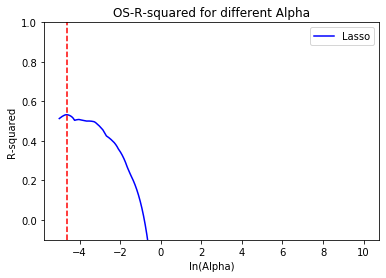

Optimal alpha for Lasso=0.009701608850454109, best OS R_2=0.5327258349173565


In [105]:
alphas = np.exp(np.linspace(-5,10,10000)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha\
(2,train_X,train_Y,test_X,test_Y,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

Tiny alpha, implies very little regularization needed

In [106]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)
'''alpha:Regularization strength; must be a positive float. 
Regularization improves the conditioning of the problem and reduces the variance of the estimates. 
******Larger values specify stronger regularization.******
'''
rel_coefs = list()
Lasso.fit(train_X,train_Y)
for col,coef in zip(train_X.columns,Lasso.coef_):
    if coef>0:
        rel_coefs.append([col, coef])
        
coefs_lasso = pd.DataFrame(rel_coefs,columns=['Column Name',"Coefficient"]).sort_values(by='Coefficient',ascending=False)
coefs_lasso

,Column Name,Coefficient
6,hh_inc_50to99K,0.758643
4,num_eployed_sciences_waste_sector,0.621175
1,black_alone,0.156499
5,hh_inc_0to49K,0.144013
2,other_race_alone,0.113151
3,num_eployed_fire_sector,0.065575
0,pop_under_18,0.037273


In [107]:
test_X

,pop_under_18,pop_over_65,white_alone,black_alone,hispanic,asian_alone,other_race_alone,num_employed,num_unemployed,hh_with_snap_past12mos,num_eployed_info_sector,num_eployed_fire_sector,num_eployed_sciences_waste_sector,num_eployed_educhealthsocial_sector,num_eployed_artsentertainmentfoood_sector,num_eployed_other_sector,num_eployed_publicadmin_sector,Bronx,Brooklyn,Manhattan,Queens,hh_inc_0to49K,hh_inc_50to99K,hh_inc_100-200K,hh_inc_200K+
communitydistrict_index,,,,,,,,,,,,,,,,,,,,,,,,,
2__11,-0.228831,-0.440947,-0.541948,-0.172065,0.535219,-0.493315,-0.190780,-0.784265,0.340837,-0.034846,-0.777042,-0.644705,-0.842645,-0.078074,-0.654656,-0.708265,-0.523004,2.0,-0.654654,-0.5,-0.577350,-0.313840,-0.403750,-0.675942,-0.599755
2__06,1.641657,-0.736675,-1.045089,0.469477,1.981096,-0.846602,-0.376547,-0.588989,2.189508,2.588705,-0.819680,-0.687095,-0.743072,0.110031,-0.088022,0.041913,-0.843930,2.0,-0.654654,-0.5,-0.577350,2.208451,-0.844808,-1.344391,-0.722474
2__05,0.800957,-1.310957,-1.174412,0.061732,1.588645,-0.848335,-0.336304,-0.977361,0.922717,1.696368,-0.876915,-0.687244,-0.887666,-0.515215,-0.133002,-0.437802,-1.032254,2.0,-0.654654,-0.5,-0.577350,1.059610,-1.243269,-1.477001,-0.757949
2__09,1.365162,0.119478,-1.080279,0.492935,2.003752,-0.338234,0.095956,0.089889,1.627743,1.436749,-0.703674,-0.496191,-0.613117,0.768555,0.319909,-0.088010,0.106152,2.0,-0.654654,-0.5,-0.577350,1.584233,0.750710,-0.600037,-0.651525
3__01,0.387095,-0.817328,1.210110,-0.689316,-0.180993,-0.445032,-0.342771,0.500388,-0.378418,0.196717,1.874590,-0.062655,1.249345,-0.619891,0.551315,-0.167962,-0.463756,-0.5,1.527525,-0.5,-0.577350,0.141029,0.070814,0.406537,0.199530
3__03,0.549303,-0.892059,-0.301385,0.972526,-0.455790,-0.718157,-0.458831,-0.393213,0.430621,0.646166,0.259334,-0.575932,-0.146051,-0.297426,-0.002023,-0.332239,0.024334,-0.5,1.527525,-0.5,-0.577350,0.331131,-0.364023,-0.501179,-0.410853
3__08,-0.554359,-0.892533,-0.514907,1.067779,-0.822056,-0.711012,-0.240725,-0.334376,-0.264594,0.196717,0.493652,-0.504491,0.113031,0.060037,-0.359033,0.409194,-0.132250,-0.5,1.527525,-0.5,-0.577350,0.188678,-0.416912,-0.285913,-0.313187
3__14,0.853976,-0.147470,0.358692,0.381983,-0.568225,-0.192369,-0.224915,-0.049003,-0.044794,0.307684,-0.192784,-0.343676,-0.351825,0.801208,-0.309810,-0.287266,-0.302235,-0.5,1.527525,-0.5,-0.577350,0.182906,0.620282,-0.334667,-0.383360
3__15,0.180118,0.636202,1.155907,-0.715995,-0.845768,0.205565,-0.451285,-0.319337,-0.509415,-0.123201,-0.427870,-0.299951,-0.520035,0.178618,-0.779412,-0.503387,-0.209131,-0.5,1.527525,-0.5,-0.577350,-0.038389,0.053343,0.000908,-0.296448


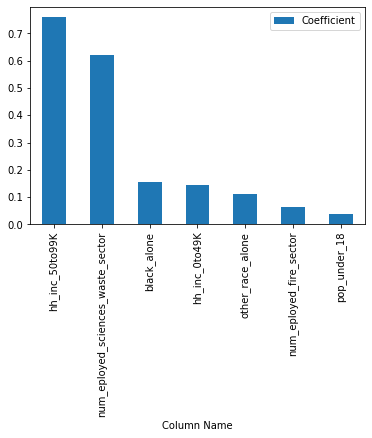

In [108]:
coefs_lasso.plot(kind='bar',x='Column Name',y='Coefficient')

In [109]:
test_Y

communitydistrict_index
2__11    0.008174
2__06    1.923676
2__05    1.831099
2__09    1.642087
3__01    2.117871
3__03    1.603147
3__08    1.351966
3__14    0.330522
3__15   -0.899999
3__11   -0.100346
1__09    0.295062
1__10    0.725518
1__11    0.469438
1__02   -1.688683
4__03    0.654444
4__06   -0.210049
4__05   -0.230172
4__09   -0.135652
5__01   -0.538747
Name: Change_Diversion_Rate_PostLockdown, dtype: float64

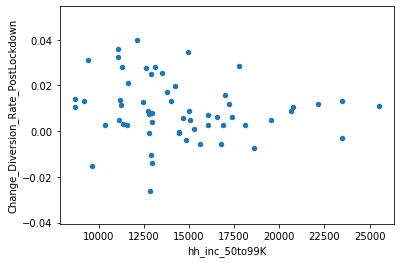

In [110]:
x_var = "hh_inc_50to99K"

modeling_df[[x_var,'Change_Diversion_Rate_PostLockdown']].plot(kind='scatter',x=x_var,y='Change_Diversion_Rate_PostLockdown')

In [111]:
resids = test_Y.copy().reset_index().set_index("communitydistrict_index")
resids['pred_Y'] = Lasso.predict(test_X)
resids['error']=resids['pred_Y']-resids['Change_Diversion_Rate_PostLockdown']
resids=resids.merge(right=cb_by_borough_idx,left_index=True,right_index=True)
resids

,Change_Diversion_Rate_PostLockdown,pred_Y,error,Borough
communitydistrict_index,,,,
2__11,0.008174,0.313163,0.304989,Bronx
2__06,1.923676,1.418702,-0.504973,Bronx
2__05,1.831099,1.095530,-0.735569,Bronx
2__09,1.642087,1.381603,-0.260484,Bronx
3__01,2.117871,0.414987,-1.702884,Brooklyn
3__03,1.603147,0.465397,-1.137751,Brooklyn
3__08,1.351966,0.280431,-1.071535,Brooklyn
3__14,0.330522,0.750153,0.419631,Brooklyn
3__15,-0.899999,-0.582298,0.317701,Brooklyn


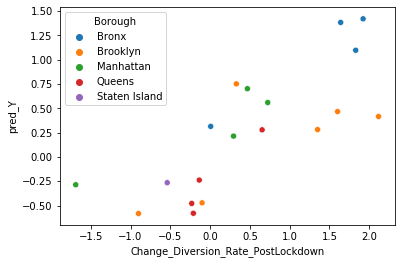

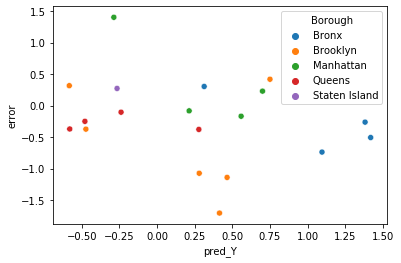

In [112]:
sns.scatterplot(data=resids,x='Change_Diversion_Rate_PostLockdown',y='pred_Y',hue='Borough')
plt.show()
sns.scatterplot(data=resids,y='error',x='pred_Y',hue='Borough')

Write up for the team

**Regression Modeling** 
As we are predicting a continuous variable, a linear regression is our ideal model. Linear regression also has the benefit of being highly interpretable, in that we can see which coefficients are most highly correlated with predicting our target variable.

In this instance, the demographic and economic data were all available for each community district in raw numbers. Additionally, we engineered two features. The first being a categorical representation of each district's borough, dropping the Staten Island column to avoid perfect multi co-linearity. As borough recycling patterns could differ across the city, this felt like a useful input. The second engineered column was bins of the household income numbers to avoid too granular of household amounts. These were aggregated to 0-49K,50-100K,100-200K and 200K+ bins.

The data was split into test and train sets at a ratio of 75%-25%, with a careful eye to ensuring by-borough splits for each. This meant that in our training set, we'd have 75% of each borough's districts in training, and the remaining 25% in testing. By doing this, this ensures that the model picks up all boroughs during training. Because we had so many (25) input variables for 40 districts (in training set), we felt regularization was important to include in the pipeline so as to avoid overfitting. Lasso regularization was chosen to aid interpretability by removing coefficients entirely. This also required scaling all data by a standard scaler so each regressor was on an equal scale. An optimal alpha, the regularization strength parameter, was derived by testing out-of-sample r2 across a whole host of values - ultimately, an extremely low alpha (implying weak regularization) was best.

**Results and Interpretation** 
Our regression model ultimately was able to achieve an out-of-sample r2 of .53, indicating moderate predictability of the change in diversion rate from our input features. Coefficients that were most predictive of diversion rate included having more households with 50-99K income, number of employees in the sciences / waste management sector, number of black residents and households with 0-49K income. The takeaway here is that characteristics associated with more diverse, lower income districts had higher diversion rates post lockdown than before. There could be numerous explanations for this, but ultimately the map of diversion rate changes also backs this up.

